## tweets emotion prediction
homework in DMLab2  
[link to Kaggle](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework)

數據集為 Twitter 上抓取，並已經根據原始文本中的特定標籤標記了這些推文的情緒。
數據集中有 8 個類別（或稱情緒）：憤怒 (anger)、期待 (anticipation)、厭惡 (disgust)、恐懼 (fear)、悲傷 (sadness)、驚訝 (surprise)、信任 (trust) 和喜悅 (joy)。

需要先對數據進行清理，進行一些預處理。然後，應用特徵工程或您在資料挖掘課程中學過或沒學過的其他數據挖掘技術。最終目標是學習一個能夠預測每條推文背後情緒的模型。

## 1.1 Load data
explore the raw data (.json) in explore_json.ipynb in file under Homework
transform it to dataframe 載入原始資料集（推文）並查看內容   

In [2]:
import json
import pandas as pd

# 存儲提取數據的列表
tweets_data = []

# 讀取 JSON 文件
with open('dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as file:
    for line in file:
        try:
            # 解析 JSON 每行
            tweet = json.loads(line)
            # 提取所需的欄位
            tweet_id = tweet["_source"]["tweet"].get("tweet_id")
            text = tweet["_source"]["tweet"].get("text")
            #hashtags = tweet["_source"]["tweet"].get("hashtags", [])
            #crawldate = tweet.get("_crawldate")

            # 將提取的欄位存入字典，並添加到列表中
            tweets_data.append({
                "tweet_id": tweet_id,
                "text": text,
                #"hashtags": hashtags,
                #"crawldate": crawldate
            })
        except json.JSONDecodeError as e:
            print("JSON decode error:", e)

# 將提取的數據轉換為 DataFrame
df = pd.DataFrame(tweets_data)

# 查看數據框內容
print(df)

         tweet_id                                               text
0        0x376b20  People who post "add me on #Snapchat" must be ...
1        0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2        0x28b412  Confident of your obedience, I write to you, k...
3        0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4        0x2de201  "Trust is not the same as faith. A friend is s...
...           ...                                                ...
1867530  0x316b80  When you buy the last 2 tickets remaining for ...
1867531  0x29d0cb  I swear all this hard work gone pay off one da...
1867532  0x2a6a4f  @Parcel2Go no card left when I wasn't in so I ...
1867533  0x24faed  Ah, corporate life, where you can date <LH> us...
1867534  0x34be8c             Blessed to be living #Sundayvibes <LH>

[1867535 rows x 2 columns]


### interpret for the data  
using files provided on Kaggle to classify the training and testing data  描述訓練資料集的特徵 describe features in training data
  
提供data_identification.csv以提供如何區分哪些資料為訓練集／測試集  
emotion.csv則是提供訓練集部分的資料之情緒  
  
資料總數共有1867535個(rows)，兩個欄位(column)分別註記tweet_id以及文字內容text
[1867535 rows x 2 columns]

### preprocessing 
match the tweet_id to compact identification and emotion
  
其中因為測試集中並無提供情緒資料（待提交），在compact時使用how='outer'防止後續處理將所有測試資料集過濾掉

In [3]:
classify = pd.read_csv('dm-2024-isa-5810-lab-2-homework/data_identification.csv')  # 包含 tweet_id 和 identification
emotion = pd.read_csv('dm-2024-isa-5810-lab-2-homework/emotion.csv')  # 包含 tweet_id 和 emotion
data = pd.merge(df, classify, on='tweet_id', how='inner')
data = pd.merge(data, emotion, on='tweet_id', how='outer')
# data # 將情緒特徵及資料分類欄位加入相同dataframe

資料總數不變，但多兩個欄位以區分為測試或訓練集，以及該推文對應的情緒（含NaN），為測試集之空資料點。

In [4]:
# 將 data_identification 中 identification 欄位值為 'train' 的選出來作為訓練集
train_data = data[data['identification'] == 'train']

# 將 identification 欄位值為 'test' 的選出來作為測試集
test_data = data[data['identification'] == 'test']

# 所有情感emotion in emotion.csv
emotions = data['emotion'].unique()

# 使用字典來存儲不同情感的訓練集
train_data_by_emotion = {emotion: train_data[train_data['emotion'] == emotion] for emotion in emotions}

# 使用字典管理子 DataFrame
sub_dfs = {emotion: train_data_by_emotion[emotion] for emotion in emotions}
sub_dfs['anger'] # example for extract specific emotion
train_data
test_data

,tweet_id,text,identification,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN
9,0x218443,When do you have enough ? When are you satisfi...,test,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",test,NaN
...,...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",test,NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",test,NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN


需使用情緒做特徵提取時用 print(sub_dfs['anger'].head())直接從datareame中提取  
使用sample減少資料量，以減少訓練時間

---
### 1.2 Save data  
儲存資料，用比較不佔空間且容易在跨平台使用的格式  
save data in smaller size

In [5]:
import pandas as pd

## save to pickle file
train_data.to_pickle("train_data.pkl") 
test_data.to_pickle("test_data.pkl")

## load a pickle file
train_data = pd.read_pickle("train_data.pkl")
test_data = pd.read_pickle("test_data.pkl")
test_data # already check the size is 411972

,tweet_id,text,identification,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN
9,0x218443,When do you have enough ? When are you satisfi...,test,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",test,NaN
...,...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",test,NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",test,NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN


---
### 1.3 Exploratory data analysis (EDA)

繪製出所有訓練資料集的情感分布（百分比）

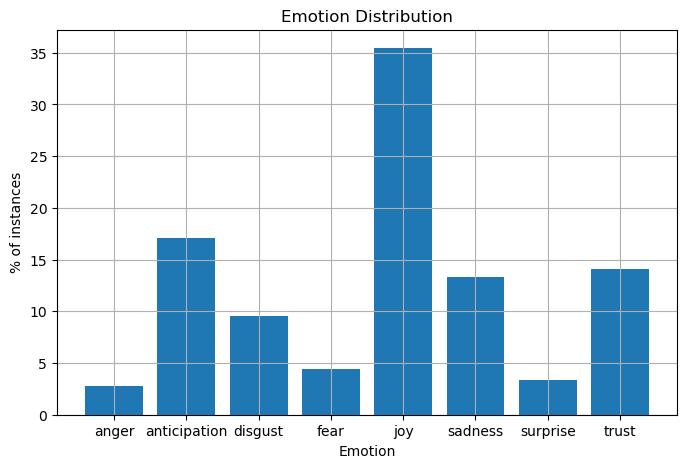

In [6]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# `emotions` 是包含所有情感類別的列表，在先前已有定義； `train_data` 包含所有訓練數據
labels = emotions
post_total = len(train_data)

# 計算每個情感的頻率 frequency
d_bar = train_data.groupby(['emotion']).count()['text'] / post_total * 100  # 計算每個情感的佔比（百分比）

# 繪製直方圖
fig, ax = plt.subplots(figsize=(8, 5))
plt.bar(d_bar.index, d_bar.values)  # 使用 d_bar 進行繪製

# 設置圖表標題和標籤
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion Distribution')
plt.grid(True)
plt.show()

可以觀察到在所有訓練集中，分佈最多的是joy（愉悅、快樂）。 此百分比代表了被發布的推文中，隨著貼文帶著的情緒。  
  
接著開始分析文本，將文字轉換成向量

## 2. Feature engineering


### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [9]:
import nltk
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_data['text'])

train_data_BOW_features_500 = BOW_500.transform(train_data['text'])

## check dimension
train_data_BOW_features_500.shape

## adjust its type for visualize
train_data_BOW_features_500.toarray()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [10]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
"😂" in feature_names_500

True

### Using TF-IDF
Using scikit-learn ```TfidfVectorizer``` perform word frequency and use these as features to train a model.  
使用不同的向量化工具

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 初始化 TfidfVectorizer，并限制特征数为 1000
tfidf_vect = TfidfVectorizer(max_features=1000)

# 使用 TF-IDF 向量化器进行训练集和测试集的向量化
train_tfidf = tfidf_vect.fit_transform(train_data["text"])
test_tfidf = tfidf_vect.transform(test_data["text"])

# 获取特征名称列表
feature_names_tf = tfidf_vect.get_feature_names_out()

---
## 3. Model


### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  

In [12]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_data['text'])
y_train = train_data['emotion']

#X_test = BOW_500.transform(test_data['text'])
#y_test = test_data['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
#print('X_test.shape: ', X_test.shape)
#print('y_test.shape: ', y_test.shape)

X_train.shape:  (1455563, 500)
y_train.shape:  (1455563,)


In [18]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)


from sklearn.metrics import accuracy_score

# 計算訓練集的準確度(Decision Tree)
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)

# 輸出準確度，將結果四捨五入保留兩位小數
print('training accuracy: {}'.format(round(acc_train, 2)))
DTA = round(acc_train, 2)

training accuracy: 0.93


### 3.1-1 Naive Bays

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: 特徵提取 (BOW)
vectorizer = CountVectorizer(max_features=500)  # 設置最大特徵數為 500
X_train = vectorizer.fit_transform(train_data["text"])
X_test = vectorizer.transform(test_data["text"])
y_train = train_data["emotion"]
y_test = test_data["emotion"]

# Step 2: 建立和訓練 Naive Bayes 模型
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 3: 模型預測
y_train_pred = nb_model.predict(X_train)

# 計算訓練集的準確度(Naive Bayes)
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)

# 輸出準確度，將結果四捨五入保留兩位小數
print('training accuracy: {}'.format(round(acc_train, 2)))
NBA = round(acc_train, 2)

training accuracy: 0.43


---
## 4. Results Evaluation

在此競賽中，只有提供training data，我們需要提交的是對test data的預測

In [15]:
# 使用上面訓練的模型來預測test的情緒，測試決策樹還有Naive Bays不同訓練方式出來的模型
print('Decision Tree Accuracy=', DTA)
print('Naive Bayes Accuracy', NBA)

Decision Tree Accuracy= 0.97
Naive Bayes Accuracy 0.43


In [20]:
# 分別使用兩種模型來訓練測試資料集
DT_test_pred = DT_model.predict(X_test)
#NB_test_pred = nb_model.predict(X_test)
#print(type(DT_test_pred))

In [1]:
import pandas as pd

result_df = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': DT_test_pred
})

# 將 DataFrame 保存為 CSV 文件，並且不包含索引列
result_df.to_csv("prediction_results_ver1.csv", index=False)

test_data

NameError: name 'test_data' is not defined